# 0. Setups

In [152]:
import os
import time
import sys

import numpy as np
import pandas as pd
from skimage import io, transform, exposure
import matplotlib.pyplot as plt
import albumentations as Alb
# import tifffile
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchinfo import summary
from tqdm import tqdm

# 1. Configuration

In [153]:
class CFG:
    """
    Configuration class for the blood vessel segmentation project.
    """
    # ============== Data Paths =============
    DATASET_NAME = "kidney_1_dense"
    DATASET_DIRECTORY = os.path.join("..", "data")
    TRAIN_DATASET_DIRECTORY = os.path.join(DATASET_DIRECTORY, "train", DATASET_NAME)
    TEST_DATASET_DIRECTORY = os.path.join(DATASET_DIRECTORY, "test", DATASET_NAME)

    # ============== Model Paths =============
    # List of paths to trained model weights
    CHECKPOINT_PATH = "checkpoints"
    TRAINED_MODEL_NAME = f"{DATASET_NAME}_checkpoint.pth"

    # ============== Model Configuration =============
    MODEL_NAME = 'Unet'
    BACKBONE = 'se_resnext50_32x4d'
    IN_CHANNEL = 1  # Number of input channels (e.g., 1 for grayscale images)
    OUT_CHANNEL = 1 # Number of output channels

    # ============== Image Processing Settings =============
    INPUT_IMAGE_SIZE = (512, 512)  # Size of the input images (height x width)
    GAMMA = 1
    NUM_IMAGES = 50 # Number of images


    # =============Training and Validation Parameters =============
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    VALID_ID = 1  # ID for validation dataset or fold
    BATCH_SIZE = 1  # Batch size for model training
    THRESHOLD_PERCENTILE = 0.0014109  # Threshold for post-processing
    LEARNING_RATE = 1e-4
    NUM_EPOCHS = 50
    NUM_WORKERS = 0 # Number of threds
    TRAIN_TEST_SPLIT_RATIO = 0.2 # for test subset
    

# 2. Load Dataset

### 2.1. Custom Dataset Class

In [154]:
class CustomDataset(Dataset):
    def __init__(self, image_path, mask_path=None, target_image_size=(512, 512), convert_size=True, gamma=1, image_format=".tif"):
        # File IO
        self.image_path = image_path
        self.image_format = image_format
        self.image_filenames = sorted([os.path.join(self.image_path, filename) for filename in os.listdir(self.image_path) if filename.endswith(self.image_format)])
        print(f"{len(self.image_filenames)} images are loaded.")

        # If masks (labels) are given
        self.mask_path = mask_path
        if self.mask_path:
            self.mask_filenames = sorted([os.path.join(self.mask_path, filename) for filename in os.listdir(self.mask_path) if filename.endswith(self.image_format)])
            if not len(self.mask_filenames) == len(self.image_filenames):
                raise(f"Number of images and labels are not matched: {len(self.image_filenames)} images and {len(self.mask_filenames)} labels.")
            print(f"{len(self.mask_filenames)} labels are loaded.")

        # Image processing
        self.target_image_size = target_image_size
        self.convert_size = convert_size
        self.gamma = gamma

        # Process and print the size of the first image if convert_size is True
        if self.convert_size and len(self.image_filenames) > 0:
            first_image = io.imread(self.image_filenames[0])
            resized_image = self.resize_and_pad(first_image, self.target_image_size)
            print(f"Original size: {first_image.shape}, Converted size: {resized_image.shape}")

    def __getitem__(self, index):
        # Load image
        image = io.imread(self.image_filenames[index])

        # Resize and pad the image if convert_size is True
        if self.convert_size:
            image = self.resize_and_pad(image, self.target_image_size, self.gamma)
        
        # Extract the filename
        image_filename = os.path.basename(self.image_filenames[index])

        # If masks (labels) are given
        if self.mask_path:
            mask = io.imread(self.mask_filenames[index])
            mask = self.resize_and_pad(mask, self.target_image_size, gamma=1) # mask containing 0s and 1s only.
            return image, mask, image_filename

        return image, image_filename

    def __len__(self):
        return len(self.image_filenames)

    def resize_and_pad(self, image, target_image_size, gamma=1):
        """Resize an image and add padding to keep aspect ratio."""
        # Calculate scale and padding
        h, w = image.shape[:2]
        scale = min(target_image_size[0] / h, target_image_size[1] / w)
        new_h, new_w = int(h * scale), int(w * scale)
        pad_h = (target_image_size[0] - new_h) // 2
        pad_w = (target_image_size[1] - new_w) // 2

        # Resize image with preserve_range set to True
        image_resized = transform.resize(
            image,
            (new_h, new_w),
            anti_aliasing=True,
            mode='constant',
            preserve_range=True,  # This will preserve the original image's intensity range
            order=1
        )

        # Apply gamma correction to adjust brightness
        if not gamma == 1:
            image_resized = exposure.adjust_gamma(image_resized, gamma)

        # Add a channel dimension to grayscale images if necessary
        if len(image.shape) == 2:  # Grayscale image
            image_resized = image_resized[..., np.newaxis]

        # Initialize padded image
        padded_image = np.zeros((target_image_size[0], target_image_size[1], image_resized.shape[2]), dtype=image_resized.dtype)

        # Insert the resized image into the padded image
        padded_image[pad_h:pad_h+new_h, pad_w:pad_w+new_w, :] = image_resized

        return padded_image

### 2.2. Display Function

In [155]:
def display_image(images, titles=None, max_cols=4):
    # Wrap single image in a list
    if not isinstance(images, list):
        images = [images]
        titles = [titles] if titles is not None else titles

    if titles is not None and not isinstance(titles, list):
        raise TypeError("Titles should be provided as a list or a single title for a single image.")

    if titles and len(images) != len(titles):
        raise ValueError("Every image should have a corresponding title.")

    num_images = len(images)
    cols = min(num_images, max_cols)
    rows = num_images // cols + (num_images % cols > 0)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    if rows == 1 or cols == 1:
        axes = np.array([axes])

    axes = axes.flatten()[:num_images]  # Limit to the number of images to avoid blank subplots

    for ax, img, title in zip(axes, images, titles or [None]*num_images):
        if isinstance(img, torch.Tensor):
            img = img.cpu().numpy()
            if img.ndim == 3 and img.shape[0] in [1, 3, 4]:
                img = img.transpose(1, 2, 0)
            if img.ndim == 3 and img.shape[2] == 1:
                img = img.squeeze(2)

        ax.imshow(img, cmap='gray')
        if title:
            ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

### 2.3. Load dataset and display sample image

In [156]:
image_path = os.path.join(CFG.TRAIN_DATASET_DIRECTORY, "images")
mask_path = os.path.join(CFG.TRAIN_DATASET_DIRECTORY, "labels")
dataset = CustomDataset(image_path, mask_path, target_image_size=CFG.INPUT_IMAGE_SIZE, gamma=CFG.GAMMA)

2279 images are loaded.
2279 labels are loaded.
Original size: (1303, 912), Converted size: (512, 512, 1)


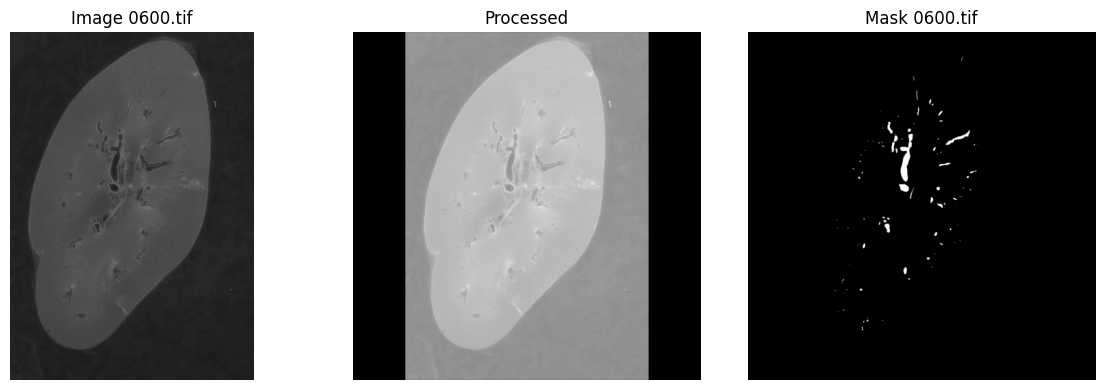

In [157]:
index = 600
original_image = io.imread(os.path.join(CFG.TRAIN_DATASET_DIRECTORY, "images", dataset[index][2]))
display_image([original_image, dataset[index][0], dataset[index][1]], [f"Image {dataset[index][2]}", "Processed", f"Mask {dataset[index][2]}"])

### 2.4. Train-Test-Split and DataLoader

In [158]:
if CFG.NUM_IMAGES:
    # Create a subset of the dataset
    indices = torch.randperm(len(dataset)).tolist()
    subset_indices = indices[:CFG.NUM_IMAGES]
    subset_dataset = Subset(dataset, subset_indices)
    dataset = subset_dataset

# Calculate the sizes of train and test sets
total_size = len(dataset)
test_size = int(total_size * CFG.TRAIN_TEST_SPLIT_RATIO)
train_size = total_size - test_size

# Split the dataset into train and test datasets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Further split the train dataset into train and validation datasets
val_size = int(train_size * CFG.TRAIN_TEST_SPLIT_RATIO)
new_train_size = train_size - val_size
train_dataset, val_dataset = random_split(train_dataset, [new_train_size, val_size])

# Create DataLoaders for train, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True, num_workers=CFG.NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS)

# 3. Image Augmentation

In [159]:
def Augement_image(image, mask):

    image_dense = torch.from_numpy(image.astype(np.float32))
    mask_dense = torch.from_numpy(mask.astype(np.float32))

    if len(image_dense.shape) == 2:
        image_dense = image_dense.unsqueeze(0)

    image_np = image_dense.permute(1, 2, 0).numpy()
    mask_np = mask_dense.numpy()

    image_list = [None, None, None, None]
    mask_list = [None, None, None, None]
    
    transform_rotate_90 = Alb.Compose([
        Alb.Rotate(limit=90, p=0.5)
    ])

    # Original image
    image_list[0] = image_np
    mask_list[0] = mask_np

    # Original image with 90-degree rotation
    augmented_rotate_90 = transform_rotate_90(image=image_np, mask=mask_np)
    image_list[1], mask_list[1] = augmented_rotate_90['image'], augmented_rotate_90['mask']

    # Original image with 180-degree rotation
    augmented_rotate_180 = transform_rotate_90(image=image_list[1], mask=mask_list[1])   
    image_list[2], mask_list[2] = augmented_rotate_180['image'], augmented_rotate_180['mask']

    # Original image with 270-degree rotation
    augmented_rotate_270 = transform_rotate_90(image=image_list[2], mask=mask_list[2])
    image_list[3], mask_list[3] = augmented_rotate_270['image'], augmented_rotate_270['mask']

    # Making the mask dimentions 3
    for i in range(4):
        if mask_list[i].ndim == 2:
            mask_list[i] = mask_list[i][..., np.newaxis]

    augmented_data_zip = list(zip(*[image_list, mask_list]))

    return augmented_data_zip

# RLE Encoding & Decoding

In [160]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    if rle == '':
        rle = '1 0'
    return rle

def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# Model

## 1.5 VGG16

In [161]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layers):
        super(VGGBlock, self).__init__()

        layers = []
        for _ in range(num_conv_layers):
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            in_channels = out_channels

        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # Change stride from 2 to 1

        self.vgg_block = nn.Sequential(*layers)

    def forward(self, x):
        return self.vgg_block(x)

class VGG16(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(VGG16, self).__init__()

        self.encoder = nn.Sequential(
            VGGBlock(in_channels, 64, 2),
            VGGBlock(64, 128, 2),
            VGGBlock(128, 256, 3),
            VGGBlock(256, 512, 3),
            VGGBlock(512, 512, 3)
        )

        self.avg_pool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [162]:
# Example usage:
in_channels = 1  # Assuming input images have 3 channels (e.g., RGB)
num_classes = 1  # Number of segmentation classes
model = VGG16(in_channels, num_classes)

print(model)
summary(model, input_size=(1, in_channels, 1024, 1024)) 

VGG16(
  (encoder): Sequential(
    (0): VGGBlock(
      (vgg_block): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): VGGBlock(
      (vgg_block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, trac

Layer (type:depth-idx)                   Output Shape              Param #
VGG16                                    [1, 1]                    --
├─Sequential: 1-1                        [1, 512, 32, 32]          --
│    └─VGGBlock: 2-1                     [1, 64, 512, 512]         --
│    │    └─Sequential: 3-1              [1, 64, 512, 512]         37,824
│    └─VGGBlock: 2-2                     [1, 128, 256, 256]        --
│    │    └─Sequential: 3-2              [1, 128, 256, 256]        221,952
│    └─VGGBlock: 2-3                     [1, 256, 128, 128]        --
│    │    └─Sequential: 3-3              [1, 256, 128, 128]        1,476,864
│    └─VGGBlock: 2-4                     [1, 512, 64, 64]          --
│    │    └─Sequential: 3-4              [1, 512, 64, 64]          5,902,848
│    └─VGGBlock: 2-5                     [1, 512, 32, 32]          --
│    │    └─Sequential: 3-5              [1, 512, 32, 32]          7,082,496
├─AdaptiveAvgPool2d: 1-2                 [1, 512, 7, 7]

# Loss function

In [163]:
class FocalLoss(nn.modules.loss._WeightedLoss):

    def __init__(self, gamma=0, size_average=None, ignore_index=-100,
                 reduce=None, balance_param=1.0):
        super(FocalLoss, self).__init__(size_average)
        self.gamma = gamma
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param

    def forward(self, input, target):
        
        assert len(input.shape) == len(target.shape)
        assert input.size(0) == target.size(0)
        assert input.size(1) == target.size(1)

        logpt = - F.binary_cross_entropy_with_logits(input, target)
        pt = torch.exp(logpt)

        focal_loss = -((1 - pt) ** self.gamma) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        return balanced_focal_loss


In [164]:
class DiceLoss(nn.Module):
    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.sigmoid()
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        return 1 - dice

In [165]:
class IoULoss(nn.Module):
    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.sigmoid()
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        IoU = (intersection + smooth) / (union + smooth)
        return 1 - IoU

In [166]:
def dice_coefficient(prediction, target):

    mask = np.zeros_like(prediction)
    mask[prediction >= 0.5] = 1

    inter = np.sum(mask * target)
    union = np.sum(mask) + np.sum(target)
    epsilon = 1e-6
    result = np.mean(2 * inter / (union + epsilon))
    return result

## Metrics

In [167]:
def calculate_metrics(y_pred, y_true):
    """
    Calculates IOU, F1 score, precision, recall, and accuracy for U-Net predictions using NumPy.

    Arguments:
    y_true -- the ground truth labels (a binary array of 0s and 1s)
    y_pred -- the predicted labels (a binary array of 0s and 1s)

    Returns:
    A dictionary containing the IOU, F1 score, precision, recall, and accuracy.
    """
    with torch.no_grad():
        # Convert probability output to binary predictions
        y_pred = (y_pred > 0.5).float()

        # Flatten the arrays
        y_true = y_true.detach().cpu().numpy().flatten()
        y_pred = y_pred.detach().cpu().numpy().flatten()

        # Calculate true positives, false positives, and false negatives
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))

        # Very small number to prevent infinity when dividing zero
        eps = 1e-8

        # Calculate IOU
        iou = tp / (tp + fp + fn + eps)

        # Calculate precision
        precision = tp / (tp + fp + eps)

        # Calculate recall
        recall = tp / (tp + fn + eps)

        # Calculate F1 score
        f1_score = 2 * (precision * recall) / (precision + recall + eps)

        # Calculate accuracy
        accuracy = np.sum(y_true == y_pred) / len(y_true)

    # Return a dictionary containing the metrics
    metrics = {"IoU_Score": iou, "F1_Score": f1_score, "Precision": precision, "Recall": recall, "Accuracy": accuracy}
    return metrics

# Training and Testing

In [168]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, optimizer, criterion, device, checkpoint_filename):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.checkpoint_filename = checkpoint_filename
        self.best_valid_loss = float('inf')

    def train_epoch(self):
        self.model.train()
        for batch_index, batch in enumerate(tqdm(self.train_loader)):
            self.optimizer.zero_grad()
            data, target, filename = batch
            
            data = data.to(self.device, dtype=torch.float32).permute(0, 3, 1, 2)
            target = target.to(self.device, dtype=torch.float32).permute(0, 3, 1, 2)

            # Convert data and target to float
            data = data.float()
            target = target.float()

            output = self.model(data)
            train_loss = self.criterion(output, target)
            train_loss.backward()
            self.optimizer.step()

            train_loss += train_loss.item()

        train_loss = train_loss/len(train_loader)
        return train_loss

    def validate(self):
        self.model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_index, batch in enumerate(tqdm(self.val_loader)):
                data, target, filename = batch
                data = data.to(self.device, dtype=torch.float32).permute(0, 3, 1, 2)
                target = target.to(self.device, dtype=torch.float32).permute(0, 3, 1, 2)

                # Convert data and target to float
                data = data.float()
                target = target.float()

                output = self.model(data)
                val_loss += self.criterion(output, target).item()
        return val_loss / len(self.val_loader.dataset)

    def train(self, epochs):
        # Initialize
        train_df = pd.DataFrame(columns=[
            "Epoch",
            "Train_Loss",
            "Valid_Loss",
            "Time_Per_Iteration"
        ])

        for epoch in range(epochs):
            print(f"\nEpoch # {epoch+1}")
            start_time = time.time()
            train_loss = self.train_epoch()
            val_loss = self.validate()
            iteration_time = (time.time() - start_time) / len(train_loader)
            
            # Saving training log
            result_data = {
                "Epoch" : epoch+1,
                "Train_Loss" : train_loss,
                "Valid_Loss" : val_loss,
                "Time_Per_Iteration" : iteration_time
            }
            train_df = pd.concat([train_df, pd.DataFrame(result_data, index=[0])], ignore_index=True)
            train_df.to_excel(os.path.join("checkpoints", f"{self.checkpoint_filename}.xlsx"))
            
            # Save model if the valid loss is lower than the previous ones
            if val_loss < self.best_valid_loss:
                print(f"Train Loss: {train_loss:2.6f}, Validation Loss: {self.best_valid_loss:2.6f} -> {val_loss: 2.6f}")
                self.best_valid_loss = val_loss
                self.save_model(self.model, "checkpoints", self.checkpoint_filename)
                print(f"Saved model at: {self.checkpoint_filename}")
            else:
                print(f"Train Loss: {train_loss:2.6f}, Validation Loss: {val_loss:2.6f}")

        return model, train_df
    
    def save_model(self, model, path, filename):
        # make directory if there is not
        if not os.path.exists(path):
            os.makedirs(path)

        # save weight values in .pth file
        torch.save(model.state_dict(), os.path.join(path, filename))

In [169]:
trainer = Trainer(model,
                  train_loader,
                  val_loader,
                  optimizer=optim.Adam(model.parameters(),lr=CFG.LEARNING_RATE),
                  criterion=DiceLoss(),
                  device=CFG.DEVICE,
                  checkpoint_filename=CFG.TRAINED_MODEL_NAME
)

model, train_df = trainer.train(epochs=CFG.NUM_EPOCHS)


Epoch # 1


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]
/var/folders/sr/nxb9m_611_32j6vhnhz46bjm0000gn/T/ipykernel_14627/2362503932.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([train_df, pd.DataFrame(result_data, index=[0])], ignore_index=True)


Train Loss: -0.062500, Validation Loss: inf -> -0.999973
Saved model at: kidney_1_dense_checkpoint.pth

Epoch # 2


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Train Loss: -0.062498, Validation Loss: -0.999973

Epoch # 3


100%|██████████| 8/8 [00:02<00:00,  2.71it/s]


Train Loss: 0.031250, Validation Loss: -0.999973

Epoch # 4


100%|██████████| 8/8 [00:02<00:00,  2.86it/s]


Train Loss: -0.062499, Validation Loss: -0.999973

Epoch # 5


100%|██████████| 8/8 [00:02<00:00,  2.91it/s]


Train Loss: -0.062363, Validation Loss: -0.999973

Epoch # 6


100%|██████████| 8/8 [00:02<00:00,  2.73it/s]


Train Loss: -0.062500, Validation Loss: -0.999973

Epoch # 7


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Train Loss: -0.062477, Validation Loss: -0.999973

Epoch # 8


100%|██████████| 8/8 [00:02<00:00,  2.88it/s]


Train Loss: -0.062500, Validation Loss: -0.999973

Epoch # 9


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


Train Loss: -0.062498, Validation Loss: -0.999973

Epoch # 10


100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


Train Loss: -0.062499, Validation Loss: -0.999973

Epoch # 11


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Train Loss: -0.062498, Validation Loss: -0.999973

Epoch # 12


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Train Loss: -0.062499, Validation Loss: -0.999973

Epoch # 13


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Train Loss: -0.062499, Validation Loss: -0.999973

Epoch # 14


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Train Loss: -0.062499, Validation Loss: -0.999973

Epoch # 15


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


Train Loss: -0.062499, Validation Loss: -0.999973

Epoch # 16


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Train Loss: -0.062500, Validation Loss: -0.999973

Epoch # 17


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Train Loss: -0.062499, Validation Loss: -0.999973

Epoch # 18


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Train Loss: -0.062499, Validation Loss: -0.999973

Epoch # 19


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Train Loss: -0.062098, Validation Loss: -0.999973

Epoch # 20


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Train Loss: -0.062499, Validation Loss: -0.999973

Epoch # 21


100%|██████████| 8/8 [00:02<00:00,  2.86it/s]


Train Loss: -0.062499, Validation Loss: -0.999973

Epoch # 22


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Train Loss: -0.062499, Validation Loss: -0.999973

Epoch # 23


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


Train Loss: 0.031250, Validation Loss: -0.999973

Epoch # 24


100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


Train Loss: -0.062500, Validation Loss: -0.999973

Epoch # 25


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Train Loss: -0.062500, Validation Loss: -0.999973

Epoch # 26


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Train Loss: -0.062476, Validation Loss: -0.999973

Epoch # 27


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Train Loss: -0.062500, Validation Loss: -0.999973

Epoch # 28


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Train Loss: -0.062363, Validation Loss: -0.999973

Epoch # 29


100%|██████████| 8/8 [00:02<00:00,  2.92it/s]


Train Loss: -0.062477, Validation Loss: -0.999973

Epoch # 30


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Train Loss: -0.062098, Validation Loss: -0.999973

Epoch # 31


100%|██████████| 8/8 [00:02<00:00,  2.93it/s]


Train Loss: -0.062499, Validation Loss: -0.999973

Epoch # 32


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]


Train Loss: -0.062499, Validation Loss: -0.999973

Epoch # 33


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Train Loss: -0.062098, Validation Loss: -0.999973

Epoch # 34


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Train Loss: -0.062500, Validation Loss: -0.999973

Epoch # 35


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Train Loss: -0.062500, Validation Loss: -0.999973

Epoch # 36


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Train Loss: -0.062500, Validation Loss: -0.999973

Epoch # 37


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Train Loss: -0.062500, Validation Loss: -0.999973

Epoch # 38


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


Train Loss: -0.062499, Validation Loss: -0.999973

Epoch # 39


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Train Loss: -0.062500, Validation Loss: -0.999973

Epoch # 40


100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


Train Loss: -0.062498, Validation Loss: -0.999973

Epoch # 41


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


Train Loss: -0.062499, Validation Loss: -0.999973

Epoch # 42


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Train Loss: -0.062500, Validation Loss: -0.999973

Epoch # 43


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Train Loss: -0.062500, Validation Loss: -0.999973

Epoch # 44


100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


Train Loss: -0.062498, Validation Loss: -0.999973

Epoch # 45


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]


Train Loss: -0.062498, Validation Loss: -0.999973

Epoch # 46


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Train Loss: -0.062499, Validation Loss: -0.999973

Epoch # 47


100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


Train Loss: -0.062499, Validation Loss: -0.999973

Epoch # 48


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Train Loss: -0.062499, Validation Loss: -0.999973

Epoch # 49


100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


Train Loss: -0.062499, Validation Loss: -0.999973

Epoch # 50


100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

Train Loss: -0.062499, Validation Loss: -0.999973
